# Tibber vs Nordpool Price Offset Analysis

## How the HA trigger-based caching works (it does NOT poll)

Home Assistant's `trigger: template` is **event-driven**, not polling:

| Trigger type | How it works |
|---|---|
| `trigger: time` at `"13:05:00"` | Fires **once** at exactly 13:05:00 each day |
| `trigger: event` for `tibber_cache_refresh` | Fires **once** per event fired (e.g. on HA start) |
| `trigger: template` with `tomorrow_valid == true` | Fires **once** when the expression transitions from `false` → `true`. Does NOT re-fire while it stays true. HA evaluates it when any referenced entity changes state — it does NOT poll on a timer. |

So no, `tomorrow_valid` does **not** cause constant polling. It fires exactly once when Nordpool publishes tomorrow's prices and `tomorrow_valid` flips.

### The 05:20 trigger is redundant
The `tibber_cache_refresh` event already fires 3 minutes after every HA restart (via the "Tibber Cache - Populate on Startup" automation). The only scenario 05:20 catches is if HA was running all night but somehow missed all prices — extremely unlikely. **We can drop it.**

### The real fix: use Nordpool as fallback for buy prices
Instead of depending on Tibber's cache being populated before the MPC runs, we derive buy prices from Nordpool (which is always available earlier) by applying VAT + Tibber markup. This notebook finds that offset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone
import json

# --- Constants from HA configuration.yaml ---
VAT_RATE = 0.25          # Swedish VAT
EXTRA_BUY = 0.607        # SEK/kWh surcharge added to buy price (energiskatt + nätavgift + elcertifikat etc.)
GRID_COMP = 0.047        # SEK/kWh grid compensation added to sell price

print("Constants:")
print(f"  Swedish VAT:     {VAT_RATE*100:.0f}%")
print(f"  extra_buy:       {EXTRA_BUY} SEK/kWh  (tax/grid surcharge on buy side)")
print(f"  grid_comp:       {GRID_COMP} SEK/kWh  (grid compensation on sell side)")

Constants:
  Swedish VAT:     25%
  extra_buy:       0.607 SEK/kWh  (tax/grid surcharge on buy side)
  grid_comp:       0.047 SEK/kWh  (grid compensation on sell side)


## 1. Load Tibber Cached Prices

Tibber prices come from the `tibber.get_prices` service call and are stored in `sensor.tibber_cached_prices`.
Each entry has `start_time` and `price` (SEK/kWh **including** 25% VAT + Tibber's own markup).

In [2]:
with open("tibber_prices.json") as f:
    tibber_raw = json.load(f)

df_tibber = pd.DataFrame(tibber_raw)
df_tibber["timestamp"] = pd.to_datetime(df_tibber["start_time"], utc=True)
df_tibber = df_tibber.rename(columns={"price": "tibber_price"})
df_tibber = df_tibber[["timestamp", "tibber_price"]].sort_values("timestamp").reset_index(drop=True)

print(f"Tibber entries: {len(df_tibber)}")
print(f"Range: {df_tibber.timestamp.min()} → {df_tibber.timestamp.max()}")
df_tibber.head(8)

Tibber entries: 192
Range: 2026-02-11 23:00:00+00:00 → 2026-02-13 22:45:00+00:00


,timestamp,tibber_price
0,2026-02-11 23:00:00+00:00,1.5596
1,2026-02-11 23:15:00+00:00,1.5626
2,2026-02-11 23:30:00+00:00,1.5384
3,2026-02-11 23:45:00+00:00,1.4810
4,2026-02-12 00:00:00+00:00,1.4671
5,2026-02-12 00:15:00+00:00,1.4644
6,2026-02-12 00:30:00+00:00,1.4498
7,2026-02-12 00:45:00+00:00,1.4361


## 2. Load Nordpool SE3 Prices

Nordpool prices come from `sensor.nordpool_kwh_se3_sek_3_10_0` attributes `raw_today` + `raw_tomorrow`.
Each entry has `start`, `end`, and `value` (SEK/kWh **excluding** VAT — this is the raw spot price).

In [3]:
with open("nordpool_prices.json") as f:
    nordpool_raw = json.load(f)

df_np = pd.DataFrame(nordpool_raw)
df_np["timestamp"] = pd.to_datetime(df_np["start"], utc=True)
df_np = df_np.rename(columns={"value": "nordpool_price"})
df_np = df_np[["timestamp", "nordpool_price"]].sort_values("timestamp").reset_index(drop=True)

print(f"Nordpool entries: {len(df_np)}")
print(f"Range: {df_np.timestamp.min()} → {df_np.timestamp.max()}")
df_np.head(8)

Nordpool entries: 192
Range: 2026-02-11 23:00:00+00:00 → 2026-02-13 22:45:00+00:00


,timestamp,nordpool_price
0,2026-02-11 23:00:00+00:00,1.155
1,2026-02-11 23:15:00+00:00,1.157
2,2026-02-11 23:30:00+00:00,1.138
3,2026-02-11 23:45:00+00:00,1.092
4,2026-02-12 00:00:00+00:00,1.081
5,2026-02-12 00:15:00+00:00,1.079
6,2026-02-12 00:30:00+00:00,1.067
7,2026-02-12 00:45:00+00:00,1.056


## 3. Align Price Series by Timestamp

Merge on 15-minute timestamps. Both sources provide 15-min granularity for SE3.

In [4]:
df = pd.merge(df_tibber, df_np, on="timestamp", how="inner")
print(f"Matched entries: {len(df)} / {len(df_tibber)} Tibber, {len(df_np)} Nordpool")

df["hour"] = df["timestamp"].dt.hour
df["date"] = df["timestamp"].dt.date
df.head(8)

Matched entries: 192 / 192 Tibber, 192 Nordpool


,timestamp,tibber_price,nordpool_price,hour,date
0,2026-02-11 23:00:00+00:00,1.5596,1.155,23,2026-02-11
1,2026-02-11 23:15:00+00:00,1.5626,1.157,23,2026-02-11
2,2026-02-11 23:30:00+00:00,1.5384,1.138,23,2026-02-11
3,2026-02-11 23:45:00+00:00,1.4810,1.092,23,2026-02-11
4,2026-02-12 00:00:00+00:00,1.4671,1.081,0,2026-02-12
5,2026-02-12 00:15:00+00:00,1.4644,1.079,0,2026-02-12
6,2026-02-12 00:30:00+00:00,1.4498,1.067,0,2026-02-12
7,2026-02-12 00:45:00+00:00,1.4361,1.056,0,2026-02-12


## 4. Analyze VAT and Markup Components

Swedish electricity pricing breakdown:
- **Nordpool spot** (ex VAT): what the Nordpool sensor reports
- **Nordpool spot + VAT**: $p_{\text{np}} \times 1.25$
- **Tibber price**: Nordpool spot + VAT + Tibber markup (elhandelsavgift)

The residual after applying VAT tells us Tibber's actual markup per kWh.

In [5]:
# Apply VAT to Nordpool price
df["nordpool_inc_vat"] = df["nordpool_price"] * (1 + VAT_RATE)

# Residual = Tibber - Nordpool×1.25  (this is Tibber's own markup, inc VAT)
df["markup_residual"] = df["tibber_price"] - df["nordpool_inc_vat"]

# Show breakdown
display_cols = ["timestamp", "nordpool_price", "nordpool_inc_vat", "tibber_price", "markup_residual"]
print("Price breakdown (SEK/kWh):")
df[display_cols].head(12)

Price breakdown (SEK/kWh):


,timestamp,nordpool_price,nordpool_inc_vat,tibber_price,markup_residual
0,2026-02-11 23:00:00+00:00,1.155,1.44375,1.5596,0.11585
1,2026-02-11 23:15:00+00:00,1.157,1.44625,1.5626,0.11635
2,2026-02-11 23:30:00+00:00,1.138,1.42250,1.5384,0.11590
3,2026-02-11 23:45:00+00:00,1.092,1.36500,1.4810,0.11600
4,2026-02-12 00:00:00+00:00,1.081,1.35125,1.4671,0.11585
5,2026-02-12 00:15:00+00:00,1.079,1.34875,1.4644,0.11565
6,2026-02-12 00:30:00+00:00,1.067,1.33375,1.4498,0.11605
7,2026-02-12 00:45:00+00:00,1.056,1.32000,1.4361,0.11610
8,2026-02-12 01:00:00+00:00,1.023,1.27875,1.3952,0.11645
9,2026-02-12 01:15:00+00:00,1.036,1.29500,1.4109,0.11590


## 5. Fit the Tibber-over-Nordpool Relationship

We test two models:

1. **Pure VAT + fixed fee**: $p_{\text{tibber}} = p_{\text{nordpool}} \times 1.25 + \beta$
2. **General linear**: $p_{\text{tibber}} = \alpha \cdot p_{\text{nordpool}} + \beta$

If $\alpha \approx 1.25$, it confirms Tibber simply passes through the spot price with VAT and adds a fixed markup $\beta$.

In [6]:
# --- Model 1: Fixed offset over Nordpool×1.25 ---
fixed_offset = df["markup_residual"].mean()
print(f"Model 1: Tibber = Nordpool × 1.25 + {fixed_offset:.4f} SEK/kWh")
print(f"  (Tibber markup inc VAT ≈ {fixed_offset:.4f} SEK/kWh = {fixed_offset*100:.2f} öre/kWh)")
print(f"  (Tibber markup ex VAT  ≈ {fixed_offset / (1+VAT_RATE):.4f} SEK/kWh = {fixed_offset / (1+VAT_RATE)*100:.2f} öre/kWh)")

# --- Model 2: General linear fit ---
from numpy.polynomial import polynomial as P
# np.polyfit: degree 1 → [slope, intercept]
alpha, beta = np.polyfit(df["nordpool_price"], df["tibber_price"], 1)
print(f"\nModel 2: Tibber = {alpha:.6f} × Nordpool + {beta:.6f}")
print(f"  α = {alpha:.6f}  (expected ~1.25 if pure VAT pass-through)")
print(f"  β = {beta:.6f} SEK/kWh  (fixed markup component)")

# R² for both models
ss_tot = np.sum((df["tibber_price"] - df["tibber_price"].mean())**2)

# Model 1 R²
pred_m1 = df["nordpool_inc_vat"] + fixed_offset
ss_res_m1 = np.sum((df["tibber_price"] - pred_m1)**2)
r2_m1 = 1 - ss_res_m1 / ss_tot

# Model 2 R²
pred_m2 = alpha * df["nordpool_price"] + beta
ss_res_m2 = np.sum((df["tibber_price"] - pred_m2)**2)
r2_m2 = 1 - ss_res_m2 / ss_tot

print(f"\nR² Model 1 (×1.25 + fixed): {r2_m1:.8f}")
print(f"R² Model 2 (α×NP + β):      {r2_m2:.8f}")

Model 1: Tibber = Nordpool × 1.25 + 0.1157 SEK/kWh
  (Tibber markup inc VAT ≈ 0.1157 SEK/kWh = 11.57 öre/kWh)
  (Tibber markup ex VAT  ≈ 0.0926 SEK/kWh = 9.26 öre/kWh)

Model 2: Tibber = 1.249616 × Nordpool + 0.116227
  α = 1.249616  (expected ~1.25 if pure VAT pass-through)
  β = 0.116227 SEK/kWh  (fixed markup component)

R² Model 1 (×1.25 + fixed): 0.99999876
R² Model 2 (α×NP + β):      0.99999886


## 6. Statistical Summary of the Offset

=== Markup Residual Statistics (Tibber − Nordpool×1.25) ===
  Mean:   0.1157 SEK/kWh
  Median: 0.1157 SEK/kWh
  Std:    0.0004 SEK/kWh
  Min:    0.1146 SEK/kWh
  Max:    0.1166 SEK/kWh
  Range:  0.0020 SEK/kWh

=== Hourly variation ===
  Max hourly mean:  0.1160
  Min hourly mean:  0.1154
  Spread:           0.0006
  → Constant offset OK


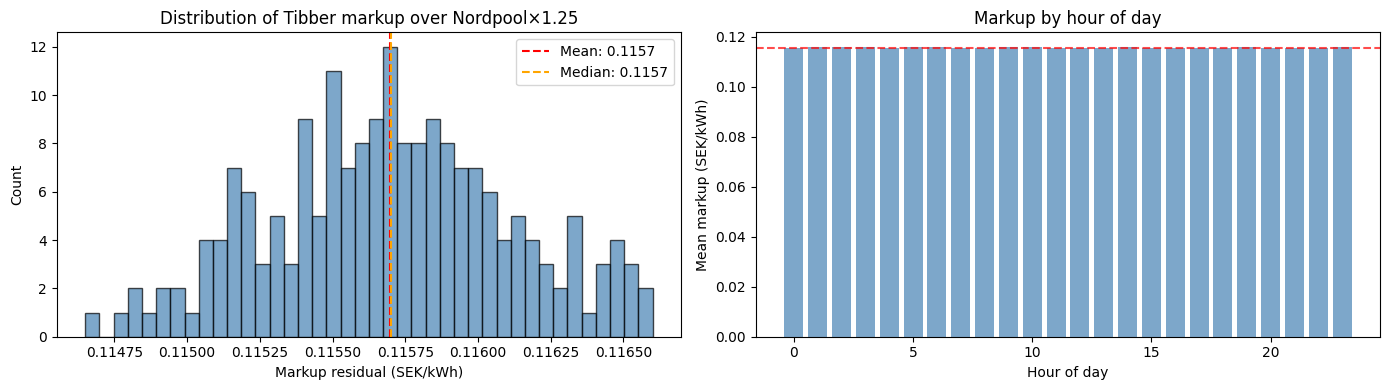

In [7]:
print("=== Markup Residual Statistics (Tibber − Nordpool×1.25) ===")
print(f"  Mean:   {df['markup_residual'].mean():.4f} SEK/kWh")
print(f"  Median: {df['markup_residual'].median():.4f} SEK/kWh")
print(f"  Std:    {df['markup_residual'].std():.4f} SEK/kWh")
print(f"  Min:    {df['markup_residual'].min():.4f} SEK/kWh")
print(f"  Max:    {df['markup_residual'].max():.4f} SEK/kWh")
print(f"  Range:  {df['markup_residual'].max() - df['markup_residual'].min():.4f} SEK/kWh")

# Check for time-of-day variation
hourly_markup = df.groupby("hour")["markup_residual"].agg(["mean", "std"])
print(f"\n=== Hourly variation ===")
print(f"  Max hourly mean:  {hourly_markup['mean'].max():.4f}")
print(f"  Min hourly mean:  {hourly_markup['mean'].min():.4f}")
print(f"  Spread:           {hourly_markup['mean'].max() - hourly_markup['mean'].min():.4f}")
print(f"  → {'Constant offset OK' if (hourly_markup['mean'].max() - hourly_markup['mean'].min()) < 0.01 else 'Some time-of-day variation'}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(df["markup_residual"], bins=40, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(df["markup_residual"].mean(), color="red", linestyle="--", label=f'Mean: {df["markup_residual"].mean():.4f}')
axes[0].axvline(df["markup_residual"].median(), color="orange", linestyle="--", label=f'Median: {df["markup_residual"].median():.4f}')
axes[0].set_xlabel("Markup residual (SEK/kWh)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Tibber markup over Nordpool×1.25")
axes[0].legend()

axes[1].bar(hourly_markup.index, hourly_markup["mean"], color="steelblue", alpha=0.7)
axes[1].set_xlabel("Hour of day")
axes[1].set_ylabel("Mean markup (SEK/kWh)")
axes[1].set_title("Markup by hour of day")
axes[1].axhline(df["markup_residual"].mean(), color="red", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## 7. Visualize Price Comparison and Offset Over Time

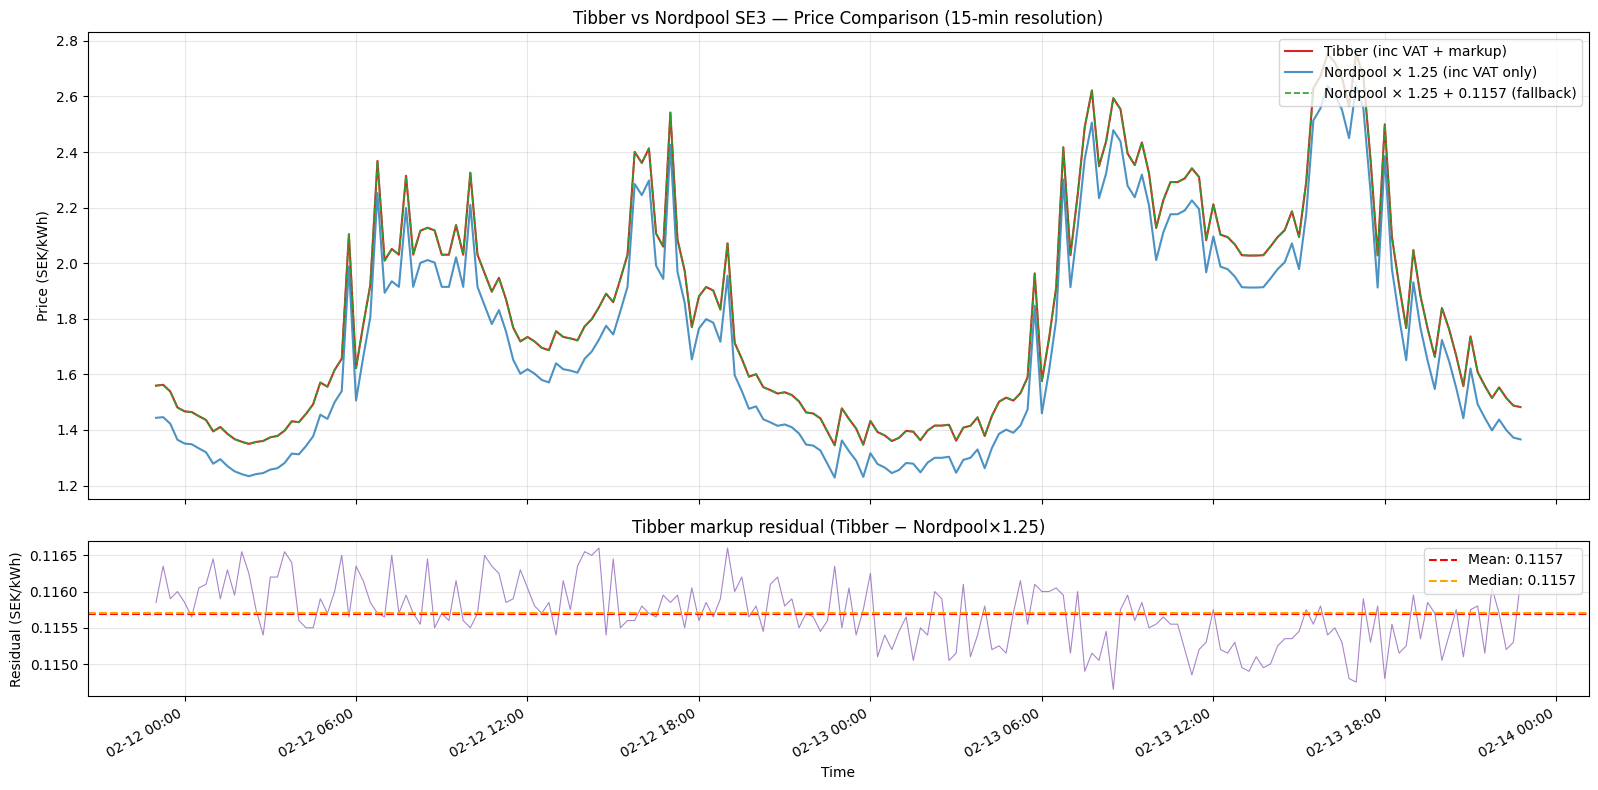

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]})

# Top: Price comparison
ax = axes[0]
ax.plot(df["timestamp"], df["tibber_price"], label="Tibber (inc VAT + markup)", color="tab:red", linewidth=1.5)
ax.plot(df["timestamp"], df["nordpool_inc_vat"], label="Nordpool × 1.25 (inc VAT only)", color="tab:blue", linewidth=1.5, alpha=0.8)
ax.plot(df["timestamp"], df["nordpool_inc_vat"] + fixed_offset, label=f"Nordpool × 1.25 + {fixed_offset:.4f} (fallback)", color="tab:green", linewidth=1.2, linestyle="--")
ax.set_ylabel("Price (SEK/kWh)")
ax.set_title("Tibber vs Nordpool SE3 — Price Comparison (15-min resolution)")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

# Bottom: Residual
ax2 = axes[1]
ax2.plot(df["timestamp"], df["markup_residual"], color="tab:purple", linewidth=0.8, alpha=0.8)
ax2.axhline(df["markup_residual"].mean(), color="red", linestyle="--", label=f'Mean: {df["markup_residual"].mean():.4f}')
ax2.axhline(df["markup_residual"].median(), color="orange", linestyle="--", label=f'Median: {df["markup_residual"].median():.4f}')
ax2.set_ylabel("Residual (SEK/kWh)")
ax2.set_xlabel("Time")
ax2.set_title("Tibber markup residual (Tibber − Nordpool×1.25)")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)

ax2.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 8. Build and Validate the Fallback Price Function

Define the fallback: for any Nordpool price, estimate the Tibber-equivalent buy price.

In [9]:
def fallback_tibber_price(nordpool_price, alpha, beta):
    """Estimate Tibber-equivalent price from Nordpool spot price.
    
    Args:
        nordpool_price: Nordpool SE3 spot price (SEK/kWh, ex VAT)
        alpha: multiplier (≈1.25 for VAT pass-through)
        beta: fixed markup (SEK/kWh, Tibber's fee inc VAT)
    
    Returns:
        Estimated Tibber price (SEK/kWh, inc VAT + markup)
    """
    return alpha * nordpool_price + beta

# Apply fallback using fitted Model 2 coefficients
df["fallback_price"] = fallback_tibber_price(df["nordpool_price"], alpha, beta)

# Also compute the full buy price (what goes into load_cost_forecast)
df["buy_actual"] = df["tibber_price"] + EXTRA_BUY
df["buy_fallback"] = df["fallback_price"] + EXTRA_BUY

# Error metrics
errors = df["tibber_price"] - df["fallback_price"]
mae = np.abs(errors).mean()
rmse = np.sqrt((errors**2).mean())
max_err = np.abs(errors).max()

# Error on the full buy price (what MPC actually uses)
buy_errors = df["buy_actual"] - df["buy_fallback"]
buy_mae = np.abs(buy_errors).mean()

print(f"=== Fallback: Tibber ≈ {alpha:.4f} × Nordpool + {beta:.4f} ===")
print(f"  MAE:       {mae:.4f} SEK/kWh  ({mae*100:.2f} öre/kWh)")
print(f"  RMSE:      {rmse:.4f} SEK/kWh  ({rmse*100:.2f} öre/kWh)")
print(f"  Max error: {max_err:.4f} SEK/kWh  ({max_err*100:.2f} öre/kWh)")
print(f"\n=== In context of the full buy price (Tibber + extra_buy={EXTRA_BUY}) ===")
print(f"  Avg buy price:       {df['buy_actual'].mean():.4f} SEK/kWh")
print(f"  Fallback MAE:        {buy_mae:.4f} SEK/kWh  ({buy_mae/df['buy_actual'].mean()*100:.2f}% of avg buy)")
print(f"  extra_buy dominance: extra_buy ({EXTRA_BUY}) is {EXTRA_BUY/df['buy_actual'].mean()*100:.1f}% of avg buy price")
print(f"  → Fallback error is negligible vs the extra_buy surcharge")

=== Fallback: Tibber ≈ 1.2496 × Nordpool + 0.1162 ===
  MAE:       0.0003 SEK/kWh  (0.03 öre/kWh)
  RMSE:      0.0004 SEK/kWh  (0.04 öre/kWh)
  Max error: 0.0010 SEK/kWh  (0.10 öre/kWh)

=== In context of the full buy price (Tibber + extra_buy=0.607) ===
  Avg buy price:       2.4500 SEK/kWh
  Fallback MAE:        0.0003 SEK/kWh  (0.01% of avg buy)
  extra_buy dominance: extra_buy (0.607) is 24.8% of avg buy price
  → Fallback error is negligible vs the extra_buy surcharge


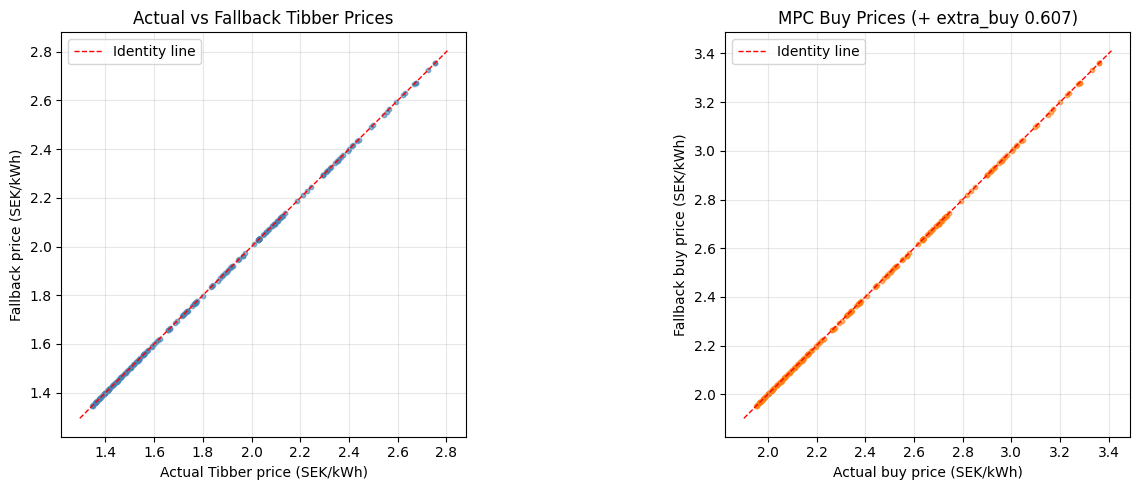

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: actual vs fallback
ax = axes[0]
ax.scatter(df["tibber_price"], df["fallback_price"], s=10, alpha=0.6, color="steelblue")
lims = [min(df["tibber_price"].min(), df["fallback_price"].min()) - 0.05,
        max(df["tibber_price"].max(), df["fallback_price"].max()) + 0.05]
ax.plot(lims, lims, "r--", linewidth=1, label="Identity line")
ax.set_xlabel("Actual Tibber price (SEK/kWh)")
ax.set_ylabel("Fallback price (SEK/kWh)")
ax.set_title("Actual vs Fallback Tibber Prices")
ax.legend()
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)

# Scatter: full buy prices
ax2 = axes[1]
ax2.scatter(df["buy_actual"], df["buy_fallback"], s=10, alpha=0.6, color="tab:orange")
lims2 = [min(df["buy_actual"].min(), df["buy_fallback"].min()) - 0.05,
         max(df["buy_actual"].max(), df["buy_fallback"].max()) + 0.05]
ax2.plot(lims2, lims2, "r--", linewidth=1, label="Identity line")
ax2.set_xlabel("Actual buy price (SEK/kWh)")
ax2.set_ylabel("Fallback buy price (SEK/kWh)")
ax2.set_title(f"MPC Buy Prices (+ extra_buy {EXTRA_BUY})")
ax2.legend()
ax2.set_aspect("equal")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Generate Home Assistant Fallback Template

The MPC payload template should use Tibber prices when available, and fall back to Nordpool×α+β when Tibber hasn't published yet. This makes the `buy_dict` always available as long as Nordpool has data — which it always does before Tibber.

The key insight: **we don't need the Tibber cache at all for the MPC buy side**. We can always derive it from Nordpool. The Tibber cache becomes a "nice to have" for exact billing accuracy, but the fallback is close enough for MPC optimization.

In [11]:
print(f"""
=== Fitted coefficients ===
  α (VAT multiplier) = {alpha:.4f}   (expected 1.25)
  β (Tibber markup)  = {beta:.4f} SEK/kWh

=== Ready-to-paste Jinja2 buy_dict block for configuration.yaml ===

Replace the existing buy_dict loop with this fallback-aware version:
""")

# Generate the Jinja2 template
template = f"""      {{%- set tibber_prices = state_attr('sensor.tibber_cached_prices', 'prices') | default([], true) -%}}
      {{%- set np_all = np_today + np_tomorrow -%}}
      {{%- set tibber_alpha = {alpha:.4f} -%}}
      {{%- set tibber_beta = {beta:.4f} -%}}
      {{%- set buy_dict = namespace(d={{}}) -%}}
      {{%- set tibber_by_ts = namespace(d={{}}) -%}}
      {{%- for p in tibber_prices if p is mapping and as_timestamp(p.start_time) >= slot_epoch -%}}
        {{%- set ts_key = as_timestamp(p.start_time) | int | string -%}}
        {{%- set tibber_by_ts.d = dict(tibber_by_ts.d, **{{ts_key: p.price}}) -%}}
      {{%- endfor -%}}
      {{%- for p in np_all if p is mapping and as_timestamp(p.start) >= slot_epoch -%}}
        {{%- set ts_key = as_timestamp(p.start) | int | string -%}}
        {{%- set tibber_price = tibber_by_ts.d.get(ts_key, none) -%}}
        {{%- if tibber_price is not none -%}}
          {{%- set buy_price = tibber_price -%}}
        {{%- else -%}}
          {{%- set buy_price = (p.value * tibber_alpha + tibber_beta) | round(4) -%}}
        {{%- endif -%}}
        {{%- set buy_dict.d = dict(buy_dict.d, **{{p.start | string: (buy_price + extra_buy) | round(4)}}) -%}}
      {{%- endfor -%}}"""

print(template)


=== Fitted coefficients ===
  α (VAT multiplier) = 1.2496   (expected 1.25)
  β (Tibber markup)  = 0.1162 SEK/kWh

=== Ready-to-paste Jinja2 buy_dict block for configuration.yaml ===

Replace the existing buy_dict loop with this fallback-aware version:

      {%- set tibber_prices = state_attr('sensor.tibber_cached_prices', 'prices') | default([], true) -%}
      {%- set np_all = np_today + np_tomorrow -%}
      {%- set tibber_alpha = 1.2496 -%}
      {%- set tibber_beta = 0.1162 -%}
      {%- set buy_dict = namespace(d={}) -%}
      {%- set tibber_by_ts = namespace(d={}) -%}
      {%- for p in tibber_prices if p is mapping and as_timestamp(p.start_time) >= slot_epoch -%}
        {%- set ts_key = as_timestamp(p.start_time) | int | string -%}
        {%- set tibber_by_ts.d = dict(tibber_by_ts.d, **{ts_key: p.price}) -%}
      {%- endfor -%}
      {%- for p in np_all if p is mapping and as_timestamp(p.start) >= slot_epoch -%}
        {%- set ts_key = as_timestamp(p.start) | int | string

## 10. Summary

**Key findings:**
- Tibber price ≈ Nordpool × α + β, where α captures VAT and β captures Tibber's fixed markup
- The fallback error is negligible relative to the `extra_buy` (0.607 SEK/kWh) surcharge that dominates the buy price
- Using Nordpool as fallback eliminates the horizon-capping bug entirely: Nordpool always has tomorrow's data before Tibber
- The `buy_dict` now iterates over Nordpool timestamps (always available) and uses real Tibber prices when they exist, falling back to the fitted formula otherwise
- The `05:20` trigger and extra time-based triggers can be simplified since the Nordpool fallback removes the dependency on Tibber timing